In [3]:
import sys
sys.path.append('./../../')

import os
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import argparse
from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.transformer_gen.ar_cond_2stream.generator import LatentGenerator as LatentGenerator2s
from modules.transformer_gen.ar_cond_1stream.generator import LatentGenerator as LatentGenerator1s
from datasets.mnist_loader import MNISTData
from datasets.cub_loader import CUBData
from datasets.cub_text_indexer import TextIndexer

from modules.common_utils import latent_to_img
from notebooks.utils import show

In [4]:
config_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/'\
              'trArC2s2s_cub_v512_ds2_nb12_cnb16_remote_continue.yaml'
CONFIG = ConfigReader(config_path=config_path)

In [5]:
data_source = CUBData(
    img_type=CONFIG.dataset_type,
    root_path=CONFIG.root_path,
    batch_size=CONFIG.BATCH_SIZE,
    description_len=CONFIG.cond_seq_size,
    prct_train_split=0.99,
    custom_transform_version=CONFIG.custom_transform_version)

train_loader = data_source.get_train_loader(batch_size=4)

In [6]:
dvae = DVAE(
    in_channels=CONFIG.in_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.num_x2downsamples,
    num_resids_downsample=CONFIG.num_resids_downsample,
    num_resids_bottleneck=CONFIG.num_resids_bottleneck,
    hidden_dim=CONFIG.hidden_dim,
    device=CONFIG.DEVICE)

dvae.eval()
dvae.load_model(
    root_path=CONFIG.vae_model_path,
    model_name=CONFIG.vae_model_name)

G = LatentGenerator2s(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    cond_num_blocks=CONFIG.cond_num_blocks,
    cond_seq_size=CONFIG.cond_seq_size,
    cond_vocab_size=CONFIG.cond_vocab_size,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    device=CONFIG.DEVICE)

G.eval()
G.load_model(
    root_path=CONFIG.model_path,
    model_name=CONFIG.model_name)

In [7]:
img_tensor, token_ids_tensor = next(iter(train_loader))

img_tensor = img_tensor.to(CONFIG.DEVICE)
token_ids_tensor = token_ids_tensor.permute(1, 0).to(CONFIG.DEVICE)

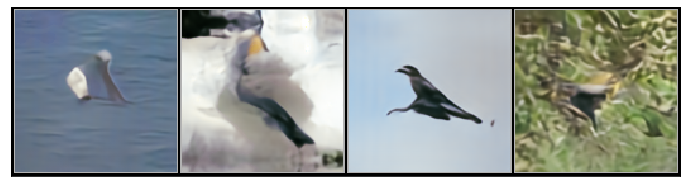

In [10]:
with torch.no_grad():
    gen_lat = G.sample(token_ids_tensor)
    
gen_img = latent_to_img(gen_lat, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

show(gen_img, figsize=(12,12), plot_grid=True)

In [11]:
tokens = token_ids_tensor.T.tolist()

tokens_processed = []
for sent_tokens in tokens:
    sent_text = []
    for t in sent_tokens:
        if t != 0:
            sent_text.append(t)
    tokens_processed.append(sent_text)

ti = TextIndexer(vocab_file_path="/u/82/sukhoba1/unix/Desktop/TA-VQVAE/data/CUB/vocab.json")

for sentence_tokens in tokens_processed:
    print(ti.ids2text(sentence_tokens))

this particular bird has a long white neck with a long orange bill
the bird has a large bill that is orange and curved
this bird has wings that are black and has a white belly
this is a small bird with a white belly black spotted breast and a brown back


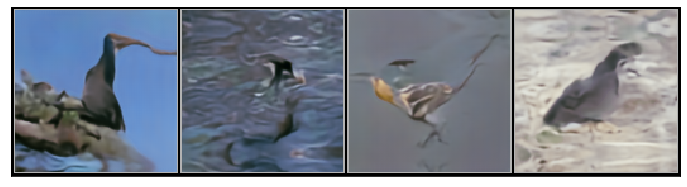

In [23]:
td = token_ids_tensor[:, [1]].repeat(1,4)

with torch.no_grad():
    gen_lat = G.sample(td)
    
gen_img = latent_to_img(gen_lat, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

show(gen_img, figsize=(12,12), plot_grid=True)